In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset
* 데이터셋 다운로드
  * web : https://finance.yahoo.com/
  * Samsung Electronics 검색 - Histroical data - 5years apply - download

In [3]:
f = 'dataset/005930.KS_5y.csv'             # 기존
# f = 'dataset/005930.KS_5y_220208.csv'    # 220208기준 5년치 다운로드

data = pd.read_csv('dataset/005930.KS_5y.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


# Compute Mid Price

In [4]:
high_prices = data['High'].values
print(type(data['High'].values))    # np.array로 반환
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2
mid_prices

<class 'numpy.ndarray'>


array([29840., 29670., 29680., ..., 41050., 40850., 41250.])

# Create Windows

In [5]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])
result[:2]    # [np, np], 즉, np의 리스트로 반환

[array([29840., 29670., 29680., 29910., 29740., 29470., 28790., 28350.,
        28430., 29020., 28680., 28790., 28940., 29410., 29660., 29510.,
        29040., 28870., 29230., 29340., 29360., 29730., 29840., 29700.,
        29350., 28840., 28680., 28820., 28940., 28820., 28600., 28060.,
        28010., 27870., 28100., 28040., 28520., 28400., 28670., 28470.,
        28160., 28060., 27570., 26570., 25980., 26160., 26130., 25910.,
        25820., 25580., 25700.]),
 array([29670., 29680., 29910., 29740., 29470., 28790., 28350., 28430.,
        29020., 28680., 28790., 28940., 29410., 29660., 29510., 29040.,
        28870., 29230., 29340., 29360., 29730., 29840., 29700., 29350.,
        28840., 28680., 28820., 28940., 28820., 28600., 28060., 28010.,
        27870., 28100., 28040., 28520., 28400., 28670., 28470., 28160.,
        28060., 27570., 26570., 25980., 26160., 26130., 25910., 25820.,
        25580., 25700., 26200.])]

# Normalize Data

In [6]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)
# print(result[:2])
print(type(result), result.shape)    # <class 'numpy.ndarray'> (1174, 51)

# split train and test data
# 9:1비율로 쪼갬
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]
# print(x_train)  
'''array([[[ 0.        ],
         [ 0.01495804],
         [-0.00729661],
         ...,
         [-0.19263043],
         [-0.19554907],
         [-0.17329442]],
'''

x_train.shape, x_test.shape, x_train

<class 'numpy.ndarray'> (1174, 51)


((1057, 50, 1),
 (117, 50, 1),
 array([[[ 0.        ],
         [-0.00905334],
         [-0.02263334],
         ...,
         [ 0.00826609],
         [ 0.04743161],
         [ 0.06376698]],
 
        [[ 0.        ],
         [ 0.00933684],
         [-0.0038305 ],
         ...,
         [ 0.10174767],
         [ 0.08618626],
         [ 0.08642566]],
 
        [[ 0.        ],
         [-0.01164191],
         [ 0.00762746],
         ...,
         [-0.07627459],
         [-0.06583701],
         [-0.06744279]],
 
        ...,
 
        [[ 0.        ],
         [-0.01164725],
         [-0.02911814],
         ...,
         [ 0.04658902],
         [ 0.06198003],
         [ 0.05698835]],
 
        [[ 0.        ],
         [ 0.00061716],
         [ 0.01666324],
         ...,
         [ 0.02941782],
         [ 0.03291504],
         [ 0.05945279]],
 
        [[ 0.        ],
         [ 0.00240385],
         [ 0.00580929],
         ...,
         [ 0.05168269],
         [ 0.05909455],
         [ 0.02

# Build a Model
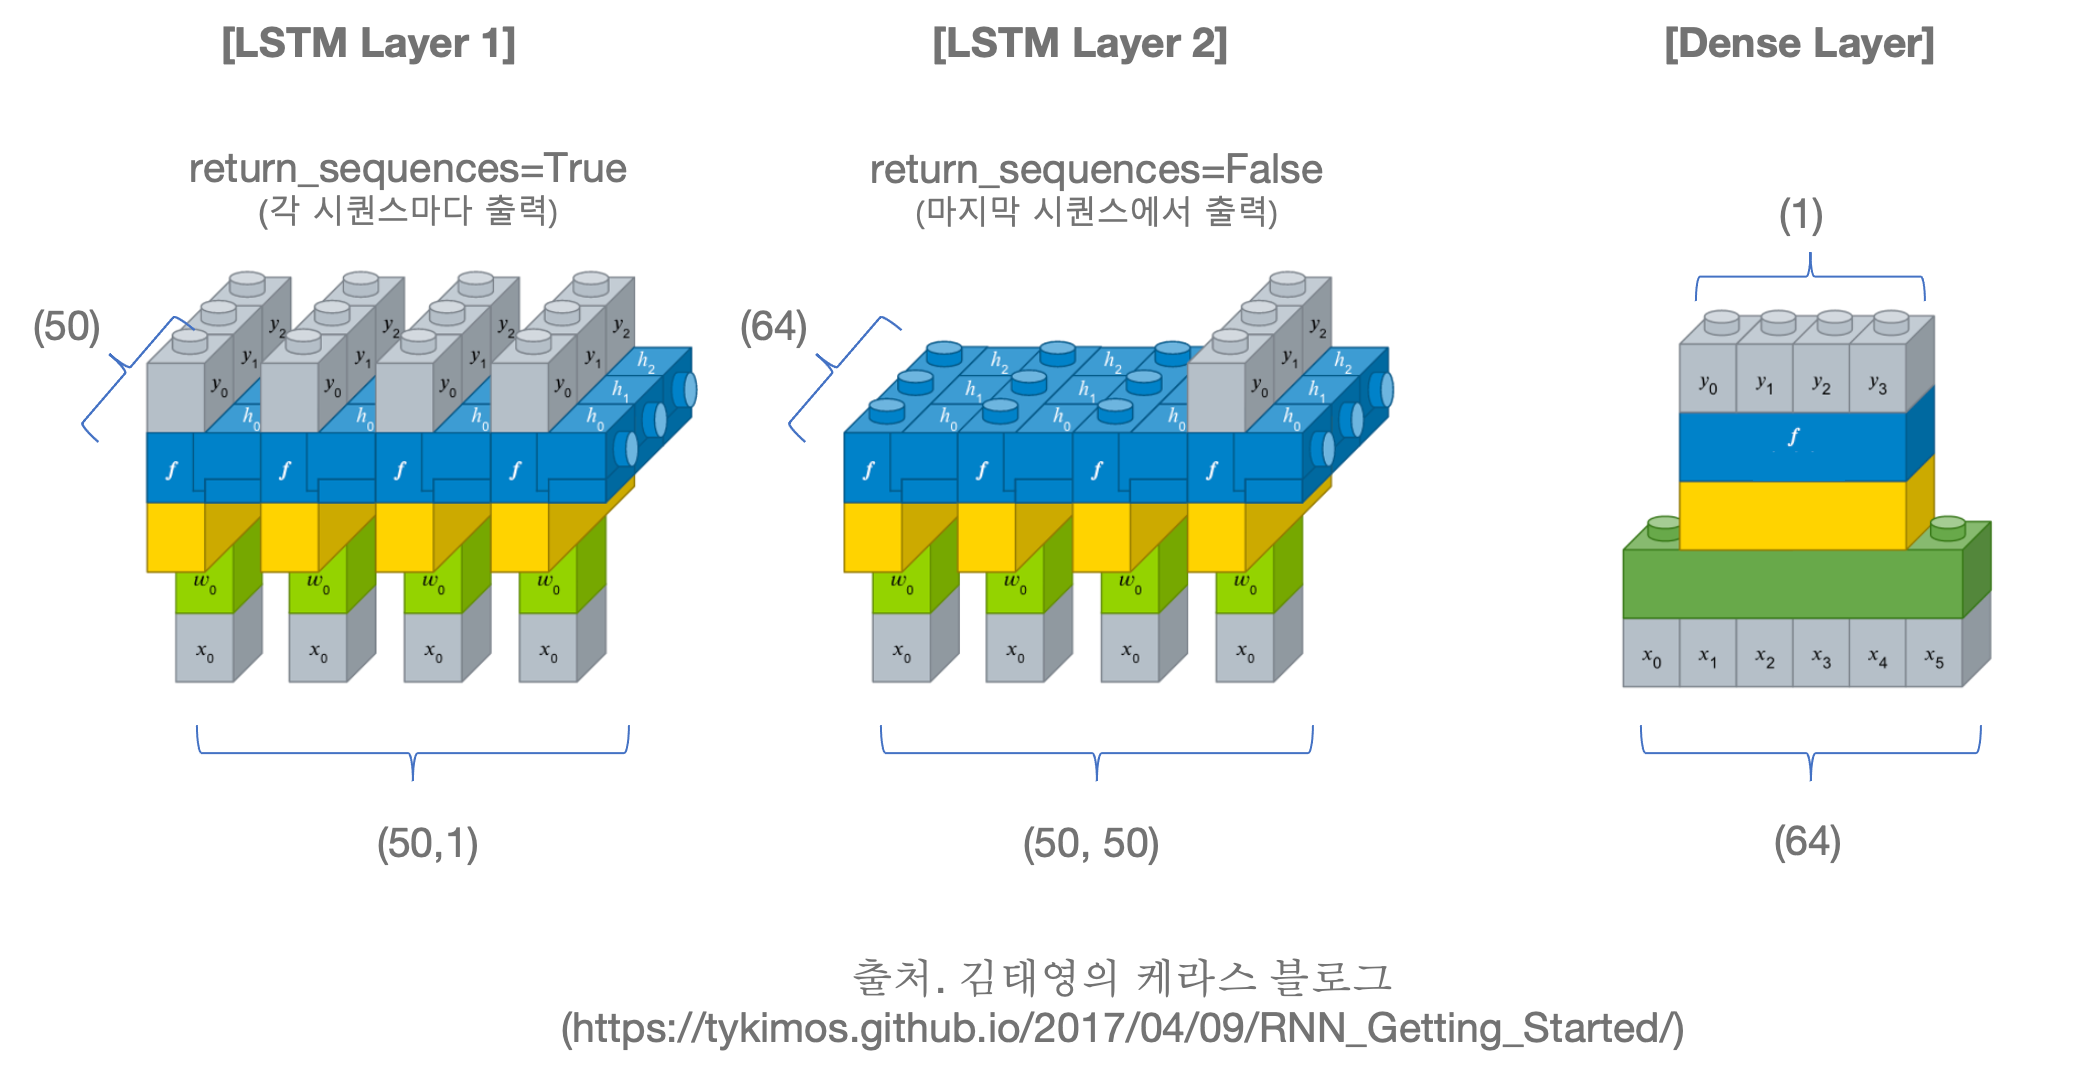

In [7]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

2022-02-08 21:01:09.654087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [8]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 7s 40ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2/20
106/106 [==============================] - 4s 34ms/step - loss: 7.2183e-04 - val_loss: 4.5357e-04
Epoch 3/20
106/106 [==============================] - 4s 34ms/step - loss: 5.2445e-04 - val_loss: 2.6423e-04
Epoch 4/20
106/106 [==============================] - 4s 33ms/step - loss: 4.4334e-04 - val_loss: 2.3267e-04
Epoch 5/20
106/106 [==============================] - 4s 33ms/step - loss: 3.4075e-04 - val_loss: 2.7063e-04
Epoch 6/20
106/106 [==============================] - 3s 32ms/step - loss: 2.7865e-04 - val_loss: 1.6595e-04
Epoch 7/20
106/106 [==============================] - 3s 33ms/step - loss: 2.4228e-04 - val_loss: 2.5318e-04
Epoch 8/20
106/106 [==============================] - 3s 32ms/step - loss: 2.3443e-04 - val_loss: 1.4255e-04
Epoch 9/20
106/106 [==============================] - 3s 31ms/step - loss: 2.3845e-04 - val_loss: 2.9328e-04
Epoch 10/20
106/106 [======

# Prediction

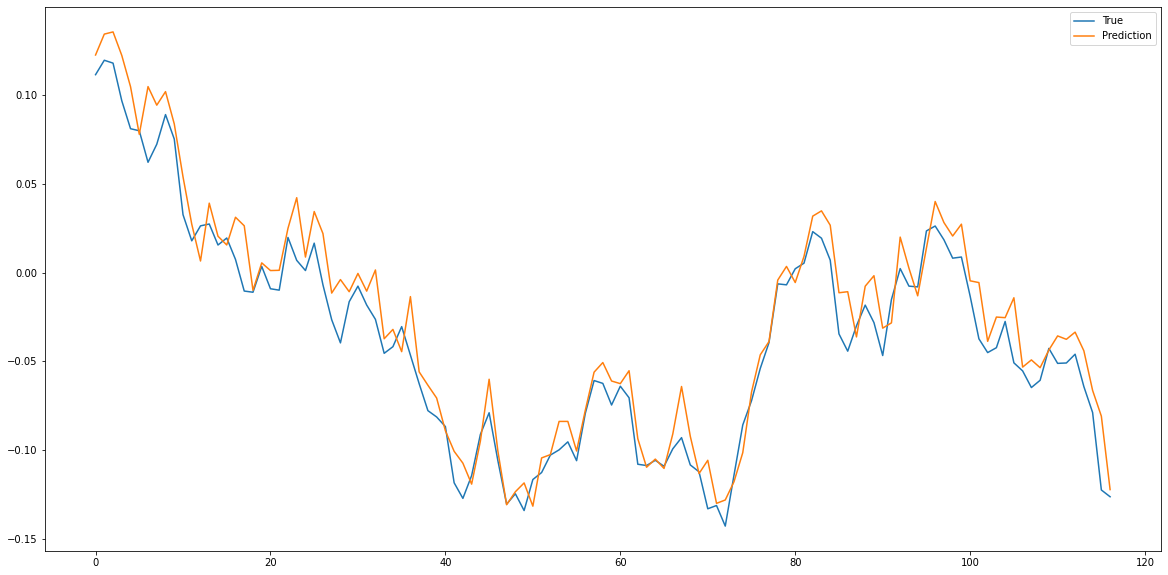

In [9]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()